In [2]:
import os
import pandas as pd
from mlxtend.plotting import plot_learning_curves,plot_confusion_matrix
import numpy as np
import io
import requests
from sklearn.linear_model import Ridge
import seaborn as sns
import matplotlib.pyplot as plt 
sns.set_style('whitegrid')
%matplotlib inline
from sklearn.model_selection import ShuffleSplit
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,validation_curve,learning_curve
from sklearn.metrics import log_loss, auc, roc_auc_score, accuracy_score,plot_confusion_matrix, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
import pydot
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,f1_score
from sklearn.ensemble import GradientBoostingClassifier as gbm
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.model_selection import GridSearchCV  
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
import warnings
warnings.filterwarnings("ignore")
import io
import timeit
import itertools
import plotly.offline as py#visualization
py.init_notebook_mode(connected=True)
from sklearn.svm import SVC

# Pre-Processing of Dataset

In [3]:
#Telecom Churn Data Set
df=pd.read_csv ("Churn_Telecom.csv")
df.pop('customerID')
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce')
df.isnull().sum()
df.dropna(inplace = True)
df['Churn'].replace(to_replace='Yes', value=1, inplace=True)
df['Churn'].replace(to_replace='No',  value=0, inplace=True)
df_1 = pd.get_dummies(df)
X,y = df_1.drop(['Churn'], axis=1),df_1['Churn']
X = df_1
X.pop('Churn')
features = X.columns.values
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X))
X.columns=features

#Bank Churn Data Set
df_cus=pd.read_csv("BANK_CHURN.csv")
df_cus.pop('RowNumber')
df_cus.pop('CustomerId')
df_cus.pop('Surname')
df_cus.EstimatedSalary = pd.to_numeric(df_cus.EstimatedSalary, errors='coerce')
df_cus.Balance = pd.to_numeric(df_cus.Balance, errors='coerce')    
df_cus.isnull().sum()
df_cus.dropna(inplace = True)
df_cus['Exited'].replace(to_replace='Yes', value=1, inplace=True)
df_cus['Exited'].replace(to_replace='No',  value=0, inplace=True)
df_1_cus = pd.get_dummies(df_cus)
X_cus,y_cus = df_1_cus.drop(['Exited'], axis=1),df_1_cus['Exited']
X_cus = df_1_cus
X_cus.pop('Exited')
features_cus = X_cus.columns.values
scaler_cus = MinMaxScaler(feature_range = (0,1))
scaler_cus.fit(X_cus)
X_cus = pd.DataFrame(scaler_cus.transform(X_cus))
X_cus.columns=features_cus
title = "Learning Curves"

# Function Definition

In [19]:
def dataset_fun():
    X1 = X
    Y1 = y
    X2= X_cus
    Y2= y_cus
    return X1,Y1,X2,Y2



def DecisionTree_fun(X_train, y_train, X_test, y_test,data_t, title,):
    f_test = []
    f_train = []
    max_depth = list(range(1,50))
    if data_t=="TELECOM":
        for t in max_depth:         
                clf = DecisionTreeClassifier(max_depth=t,criterion='entropy')
                clf.fit(X_train, y_train)
                y_pred_test = clf.predict(X_test)
                y_pred_train = clf.predict(X_train)
                f_test.append(f1_score(y_test, y_pred_test))
                f_train.append(f1_score(y_train, y_pred_train))
    else:
            for t in max_depth:         
                clf_bank = DecisionTreeClassifier(max_depth=t,criterion='entropy')
                clf_bank.fit(X_train, y_train)
                y_pred_test = clf_bank.predict(X_test)
                y_pred_train = clf_bank.predict(X_train)
                f_test.append(f1_score(y_test, y_pred_test))
                f_train.append(f1_score(y_train, y_pred_train))

    plt.plot(max_depth, f_test, 'o-', color='green', label='Test F1 Score')
    plt.plot(max_depth, f_train, 'o-', color = 'r', label='Train F1 Score')
    plt.ylabel(' F1 Score')
    plt.xlabel('Max Tree Depth')
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

def print_score(clf,X_train,y_train,X_test,y_test,train=True):
    if train:
        print("Train Results: \n")
        print("Accuracy Report: {0:.3f} \n".format(accuracy_score(y_train,clf.predict(X_train))))
        print("Classification Report: \n{}\n".format(classification_report(y_train,clf.predict(X_train))))
        print("Confusion Matrix Report: \n{}\n".format(confusion_matrix(y_train,clf.predict(X_train))))
    
        res=cross_val_score(clf,X_train,y_train,cv=10,scoring='accuracy')        
        print("Average Accuracy: \t{0:.3f}".format(np.mean(res)))
        print("Average SD: \t{0:.3f}".format(np.std(res)))


    elif train==False:
        print("Test Results: \n")
        print("Accuracy Report: {0:.3f} \n".format(accuracy_score(y_test,clf.predict(X_test))))
        print("Classification Report: \n{}\n".format(classification_report(y_test,clf.predict(X_test))))
        print("Confusion Matrix Report: \n{}\n".format(confusion_matrix(y_test,clf.predict(X_test))))
    

  


In [20]:
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(0.01, 1.0, 30)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")


    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")
    plt.tight_layout()
    return plt,test_scores, fit_times
   

def GridSearchCV_f(start_leaf_n, end_leaf_n, X_train, y_train,data_t1):
    
    if data_t1=="DT":
        param_grid = {'min_samples_leaf':np.linspace(start_leaf_n,end_leaf_n,20).round().astype('int'), 'max_depth':np.arange(1,20)}
        tree = GridSearchCV(estimator = DecisionTreeClassifier(), param_grid=param_grid, cv=10)
        tree.fit(X_train, y_train)
        print("Per Hyperparameter tuning, best parameters are:")
        print(tree.best_params_)
        return tree.best_params_['max_depth'], tree.best_params_['min_samples_leaf']
    elif data_t1=="BOOST":
        param_grid = {'min_samples_leaf':np.linspace(start_leaf_n,end_leaf_n,3).astype('int'),
                  'max_depth':[1,2,5,6],
                  'n_estimators':np.linspace(10,100,3).astype('int'),
                  'learning_rate':np.linspace(.001,.1,3)}
        tree = GridSearchCV(estimator = gbm(), param_grid=param_grid, cv=10)
        tree.fit(X_train, y_train) 
        print("Per Hyperparameter tuning, best parameters are:")
        print(tree.best_params_)
        return tree.best_params_['max_depth'], tree.best_params_['min_samples_leaf'], tree.best_params_['n_estimators'], tree.best_params_['learning_rate']
    elif data_t1=="SVM":
        C_1 = [0.1, 1, 10, 100, 1000]
        gamma_1 = [1, 0.1, 0.01, 0.001, 0.0001]
        kernel=['rbf']
        param_grid_svm = {'C': C_1, 'gamma': gamma_1,'kernel': ['rbf']}
        
        print("IN SVM")

        clf_svm = GridSearchCV(estimator = SVC(random_state=100),
                       param_grid=param_grid_svm, cv=10)
        clf_svm.fit(X_train, y_train)
        print("Per Hyperparameter tuning, best parameters are:")
        print(clf_svm.best_params_)
        return clf_svm.best_params_['C'], clf_svm.best_params_['gamma']
    elif data_t1=="NN":
        h_layers = [5, 10, 20, 30, 40, 50, 75, 100]
        learning_rate = [0.01, 0.05, .1]
        solver=['adam']
        activation=['relu']
        param_grid = {'hidden_layer_sizes': h_layers, 'learning_rate_init': learning_rate,'solver': solver,'activation': activation}

        nn = GridSearchCV(estimator = MLPClassifier(),
                       param_grid=param_grid, cv=10)
        nn.fit(X_train, y_train)
        print("Per Hyperparameter tuning, best parameters are:")
        print(nn.best_params_)
        return nn.best_params_['hidden_layer_sizes'], nn.best_params_['learning_rate_init']

    



# DECISION TREE

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
clf=DecisionTreeClassifier(max_depth=4, criterion='entropy')
clf.fit(X_train,y_train)

export_graphviz(clf,
                out_file="tree.dot",
                feature_names=features,
                class_names=['No','Yes'],
                rounded=True,
                filled=True
               )
(graph,) = pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree.png')


<img src="tree.png" width=1000% height=100%>

In [6]:
print_score(clf,X_train,y_train,X_test,y_test,train=True)

Train Resuls: 

Accuracy Report: 0.792 

Classification Report: 
              precision    recall  f1-score   support

           0       0.81      0.94      0.87      4103
           1       0.71      0.37      0.48      1477

    accuracy                           0.79      5580
   macro avg       0.76      0.66      0.68      5580
weighted avg       0.78      0.79      0.77      5580


Confusion Matrix Report: 
[[3877  226]
 [ 934  543]]

Average Accuracy: 	0.791
Average SD: 	0.013


In [7]:
print_score(clf,X_train,y_train,X_test,y_test,train=False)

Test Resuls: 

Accuracy Report: 0.778 

Classification Report: 
              precision    recall  f1-score   support

           0       0.79      0.95      0.86      1020
           1       0.69      0.33      0.44       375

    accuracy                           0.78      1395
   macro avg       0.74      0.64      0.65      1395
weighted avg       0.76      0.78      0.75      1395


Confusion Matrix Report: 
[[964  56]
 [253 122]]



In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_cus, y_cus, test_size=0.2, random_state=101)
clf=DecisionTreeClassifier(max_depth=4, criterion='entropy')
clf.fit(X_train,y_train)


export_graphviz(clf,
                out_file="tree_cus.dot",
                feature_names=features_cus,
                class_names=['No','Yes'],
                rounded=True,
                filled=True
               )
(graph,) = pydot.graph_from_dot_file('tree_cus.dot')
graph.write_png('tree_cus.png')

<img src="tree_cus.png" width=1000% height=100%>

In [9]:
print_score(clf,X_train,y_train,X_test,y_test,train=True)

Train Resuls: 

Accuracy Report: 0.841 

Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.98      0.91      6386
           1       0.81      0.28      0.41      1614

    accuracy                           0.84      8000
   macro avg       0.83      0.63      0.66      8000
weighted avg       0.84      0.84      0.81      8000


Confusion Matrix Report: 
[[6281  105]
 [1165  449]]

Average Accuracy: 	0.829
Average SD: 	0.011


In [9]:
print_score(clf,X_train,y_train,X_test,y_test,train=False)

Test Results: 

Accuracy Report: 0.846 

Classification Report: 
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      1577
           1       0.71      0.45      0.55       423

    accuracy                           0.85      2000
   macro avg       0.79      0.70      0.73      2000
weighted avg       0.83      0.85      0.83      2000


Confusion Matrix Report: 
[[1500   77]
 [ 231  192]]



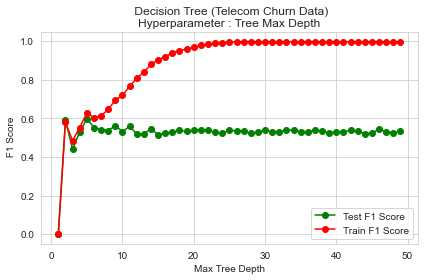

Per Hyperparameter tuning, best parameters are:
{'max_depth': 5, 'min_samples_leaf': 112}


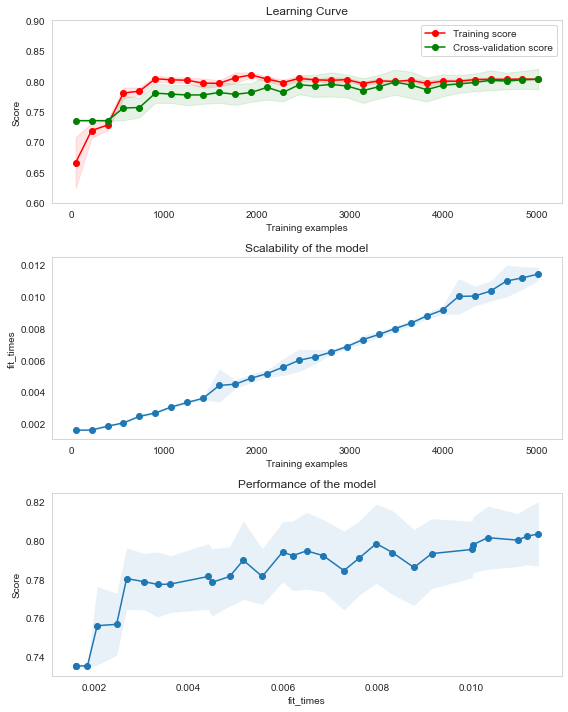

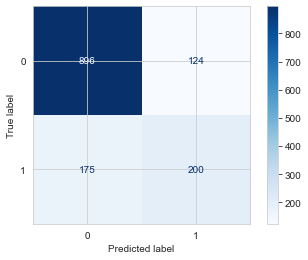

In [32]:
churnX,churnY,cusX,cusY = dataset_fun()

X_train, X_test, y_train, y_test = train_test_split(churnX, churnY, test_size=0.2, random_state=101)

DecisionTree_fun(X_train, y_train, X_test, y_test,"TELECOM",title=" Decision Tree (Telecom Churn Data)\nHyperparameter : Tree Max Depth")

fig,axes = plt.subplots(3, figsize=(8, 10))

start_leaf_n = round(0.006*len(X_train))

end_leaf_n = round(0.06*len(X_train)) 

max_depth, min_samples_leaf = GridSearchCV_f(start_leaf_n,end_leaf_n,X_train,y_train,"DT")

clf = DecisionTreeClassifier( max_depth=max_depth,min_samples_leaf=min_samples_leaf, random_state=100,criterion='entropy')

clf.fit(X_train, y_train)

plt,dt_test_scores_tel, dt_fit_times_tel=plot_learning_curve(clf, title, X_train, y_train, axes=axes, ylim=(0.6, 0.9),cv=10)

plt.show()

plot_confusion_matrix(clf, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=None)



In [33]:
print_score(clf,X_train,y_train,X_test,y_test,train=True)

Train Results: 

Accuracy Report: 0.803 

Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      4103
           1       0.64      0.59      0.61      1477

    accuracy                           0.80      5580
   macro avg       0.75      0.74      0.74      5580
weighted avg       0.80      0.80      0.80      5580


Confusion Matrix Report: 
[[3603  500]
 [ 602  875]]

Average Accuracy: 	0.804
Average SD: 	0.017


In [34]:
print_score(clf,X_train,y_train,X_test,y_test,train=False)

Test Results: 

Accuracy Report: 0.786 

Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1020
           1       0.62      0.53      0.57       375

    accuracy                           0.79      1395
   macro avg       0.73      0.71      0.71      1395
weighted avg       0.78      0.79      0.78      1395


Confusion Matrix Report: 
[[896 124]
 [175 200]]



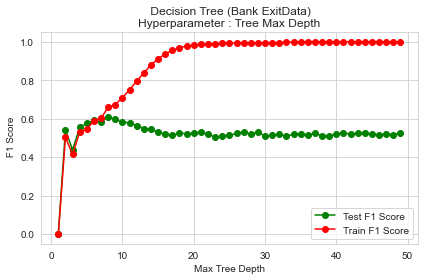

Per Hyperparameter tuning, best parameters are:
{'max_depth': 6, 'min_samples_leaf': 71}


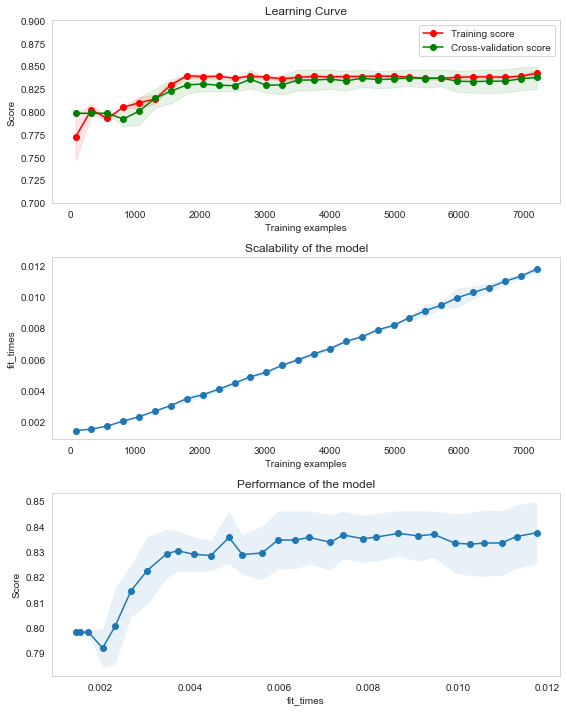

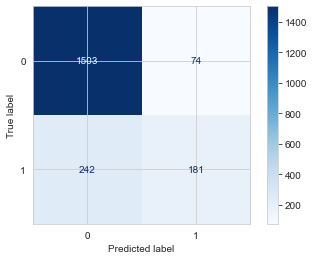

In [37]:
X_train, X_test, y_train, y_test = train_test_split(cusX, cusY, test_size=0.2, random_state=101)

DecisionTree_fun(X_train, y_train, X_test, y_test,"BANK",title=" Decision Tree (Bank ExitData)\nHyperparameter : Tree Max Depth")

#print_score(clf,X_train,y_train,X_test,y_test,train=True)



#plot_learning_curve(clf, "Learning Curve", X_train, y_train, axes=axes, ylim=(0, 1.01),cv=5)

start_leaf_n = round(0.006*len(X_train))

end_leaf_n = round(0.06*len(X_train)) 

max_depth, min_samples_leaf = GridSearchCV_f(start_leaf_n,end_leaf_n,X_train,y_train,"DT")

clf_bank = DecisionTreeClassifier( max_depth=max_depth,min_samples_leaf=min_samples_leaf, random_state=100,criterion='entropy')

clf_bank.fit(X_train, y_train)

fig,axes = plt.subplots(3, figsize=(8, 10))

plt,dt_test_scores_bank, dt_fit_times_bank=plot_learning_curve(clf, "Learning Curve", X_train, y_train, axes=axes, ylim=(0.7, .9),cv=10)

plt.show()

plot_confusion_matrix(clf_bank, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=None)



In [26]:
print_score(clf,X_train,y_train,X_test,y_test,train=True)

Train Results: 

Accuracy Report: 0.851 

Classification Report: 
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      6386
           1       0.73      0.41      0.53      1614

    accuracy                           0.85      8000
   macro avg       0.80      0.69      0.72      8000
weighted avg       0.84      0.85      0.83      8000


Confusion Matrix Report: 
[[6143  243]
 [ 947  667]]

Average Accuracy: 	0.848
Average SD: 	0.009


In [27]:
print_score(clf,X_train,y_train,X_test,y_test,train=False)

Test Results: 

Accuracy Report: 0.842 

Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.95      0.90      1577
           1       0.71      0.43      0.53       423

    accuracy                           0.84      2000
   macro avg       0.79      0.69      0.72      2000
weighted avg       0.83      0.84      0.83      2000


Confusion Matrix Report: 
[[1503   74]
 [ 242  181]]



## BOOSTING

In [12]:
def Boost_fun(X_train, y_train, X_test, y_test, max_depth, min_samples_leaf, title):
    
    f_test = []
    f_train = []
    n_estimators = np.linspace(1,300,50).astype('int')
    for a in n_estimators:         
            clf = gbm(n_estimators=a, max_depth=max_depth, 
                                             min_samples_leaf=min_samples_leaf, random_state=101)
            clf.fit(X_train, y_train)
            y_pred_test = clf.predict(X_test)
            y_pred_train = clf.predict(X_train)
            f_test.append(f1_score(y_test, y_pred_test))
            f_train.append(f1_score(y_train, y_pred_train))
      
    plt.plot(n_estimators, f_test, 'o-', color='r', label='Test F Score')
    plt.plot(n_estimators, f_train, 'o-', color = 'g', label='Train F Score')
    plt.ylabel('Model F Score')
    plt.xlabel('No. Estimators')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()



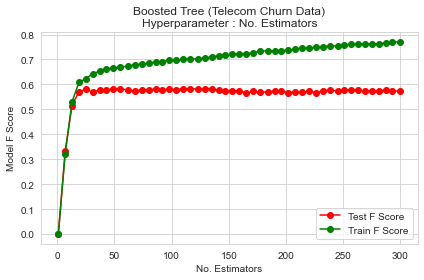

Per Hyperparameter tuning, best parameters are:
{'learning_rate': 0.0505, 'max_depth': 6, 'min_samples_leaf': 335, 'n_estimators': 100}


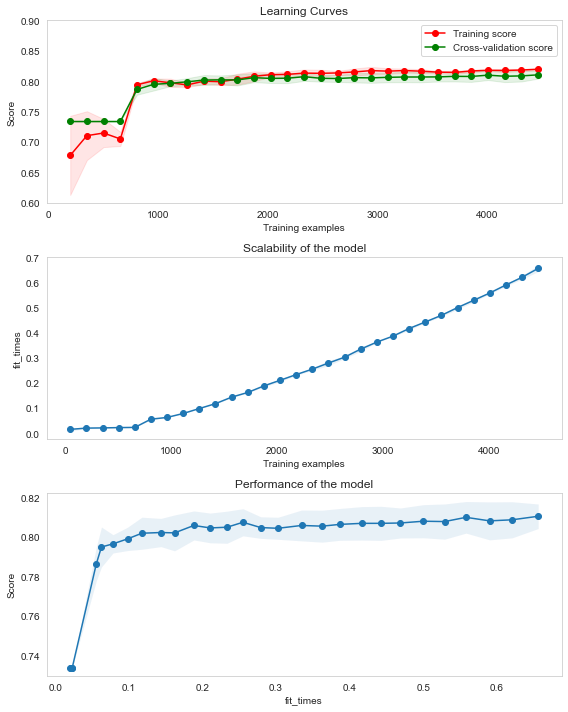

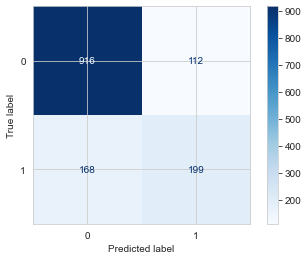

In [13]:
churnX,churnY,cusX,cusY = dataset_fun()

X_train, X_test, y_train, y_test = train_test_split(churnX,churnY, test_size=0.20)

Boost_fun(X_train, y_train, X_test, y_test, 5, 48, 
           title="Boosted Tree (Telecom Churn Data)\nHyperparameter : No. Estimators")

start_leaf_n = round(0.006*len(X_train))

end_leaf_n = round(0.06*len(X_train))

max_depth, min_samples_leaf, n_est, learn_rate = GridSearchCV_f(start_leaf_n,end_leaf_n,X_train,y_train,"BOOST")


estimator_churn = gbm(max_depth=max_depth, min_samples_leaf=min_samples_leaf, 
                                              n_estimators=n_est, learning_rate=learn_rate, random_state=100)

estimator_churn.fit(X_train, y_train)

fig,axes = plt.subplots(3, figsize=(8, 10))

plt,boost_test_scores_telecom, boost_fit_times_telecom=plot_learning_curve(estimator_churn, title, X_train, y_train, axes=axes, ylim=(0.6, 0.9),cv=5)

plt.show()

plot_confusion_matrix(estimator_churn, X_test, y_test,cmap=plt.cm.Blues,
                                 normalize=None)



In [14]:
print_score(estimator_churn,X_train,y_train,X_test,y_test,train=True)

Train Results: 

Accuracy Report: 0.821 

Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      4095
           1       0.71      0.56      0.63      1485

    accuracy                           0.82      5580
   macro avg       0.78      0.74      0.75      5580
weighted avg       0.81      0.82      0.81      5580


Confusion Matrix Report: 
[[3745  350]
 [ 648  837]]

Average Accuracy: 	0.807
Average SD: 	0.012


In [15]:
print_score(estimator_churn,X_train,y_train,X_test,y_test,train=False)

Test Results: 

Accuracy Report: 0.799 

Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1028
           1       0.64      0.54      0.59       367

    accuracy                           0.80      1395
   macro avg       0.74      0.72      0.73      1395
weighted avg       0.79      0.80      0.79      1395


Confusion Matrix Report: 
[[916 112]
 [168 199]]



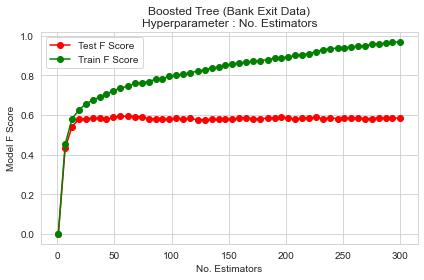

Per Hyperparameter tuning, best parameters are:
{'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 48, 'n_estimators': 100}


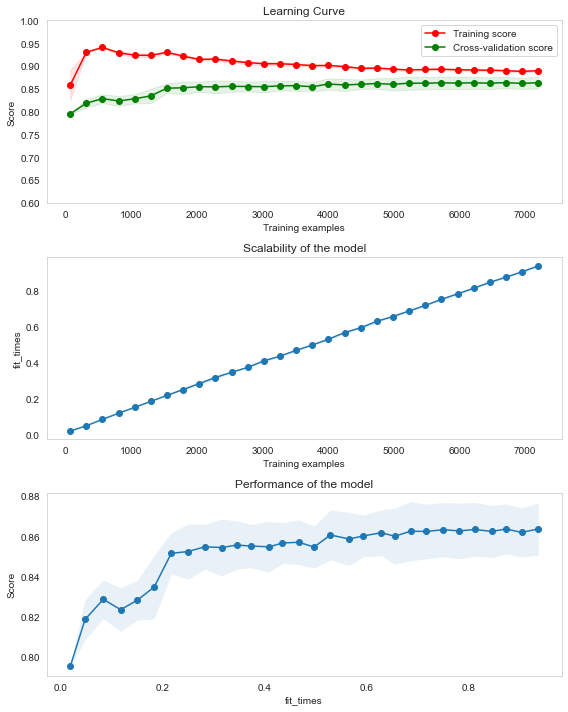

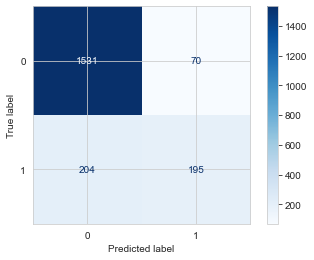

In [16]:
X_train, X_test, y_train, y_test = train_test_split(cusX,cusY, test_size=0.20)

Boost_fun(X_train, y_train, X_test, y_test, 9, 48, 
           title="Boosted Tree (Bank Exit Data)\nHyperparameter : No. Estimators")

start_leaf_n = round(0.006*len(X_train))

end_leaf_n = round(0.06*len(X_train))

max_depth, min_samples_leaf, n_est, learn_rate = GridSearchCV_f(start_leaf_n,end_leaf_n,X_train,y_train,"BOOST")

title="Learning Curve"

estimator_churn = gbm(max_depth=max_depth, min_samples_leaf=min_samples_leaf, 
                                              n_estimators=n_est, learning_rate=learn_rate, random_state=100)

estimator_churn.fit(X_train, y_train)

fig,axes = plt.subplots(3, figsize=(8, 10))

plt,boost_test_scores_bank, boost_fit_times_bank=plot_learning_curve(estimator_churn, title, X_train, y_train, axes=axes, ylim=(0.6, 1),cv=10)

plt.show()

plot_confusion_matrix(estimator_churn, X_test, y_test,cmap=plt.cm.Blues,
                                 normalize=None)


In [17]:
print_score(estimator_churn,X_train,y_train,X_test,y_test,train=True)

Train Results: 

Accuracy Report: 0.889 

Classification Report: 
              precision    recall  f1-score   support

           0       0.90      0.97      0.93      6362
           1       0.84      0.56      0.67      1638

    accuracy                           0.89      8000
   macro avg       0.87      0.77      0.80      8000
weighted avg       0.89      0.89      0.88      8000


Confusion Matrix Report: 
[[6191  171]
 [ 717  921]]

Average Accuracy: 	0.864
Average SD: 	0.013


In [18]:
print_score(estimator_churn,X_train,y_train,X_test,y_test,train=False)

Test Results: 

Accuracy Report: 0.863 

Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1601
           1       0.74      0.49      0.59       399

    accuracy                           0.86      2000
   macro avg       0.81      0.72      0.75      2000
weighted avg       0.85      0.86      0.85      2000


Confusion Matrix Report: 
[[1531   70]
 [ 204  195]]



# KNN

In [24]:

from sklearn.neighbors import KNeighborsClassifier as kNN

def KNN_fun(X_train, y_train, X_test, y_test,title):
    
    f_test = []
    f_train = []
    klist = np.linspace(1,150,20).astype('int')
    for a in klist:
        clf = kNN(n_neighbors=a,n_jobs=-1)
        clf.fit(X_train,y_train)
        y_pred_test = clf.predict(X_test)
        y_pred_train = clf.predict(X_train)
        f_test.append(f1_score(y_test, y_pred_test))
        f_train.append(f1_score(y_train, y_pred_train))
        
    plt.plot(klist, f_test, 'o-', color='r', label='Test F1 Score')
    plt.plot(klist, f_train, 'o-', color = 'b', label='Train F1 Score')
    plt.ylabel('Model F Score')
    plt.xlabel('Numbers of Neighbors')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()



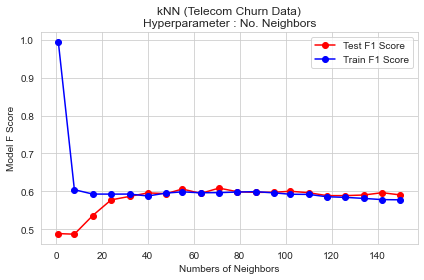

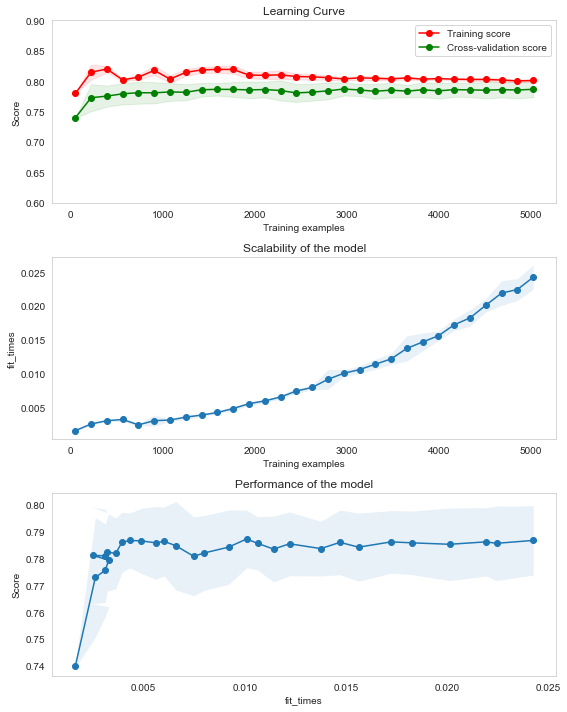

Train Resuls: 

Accuracy Report: 0.800 

Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      4129
           1       0.63      0.55      0.59      1451

    accuracy                           0.80      5580
   macro avg       0.74      0.72      0.73      5580
weighted avg       0.79      0.80      0.80      5580


Confusion Matrix Report: 
[[3657  472]
 [ 646  805]]

Average Accuracy: 	0.787
Average SD: 	0.013


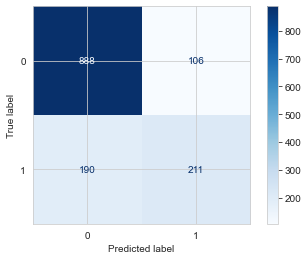

In [39]:
churnX,churnY,cusX,cusY = dataset_fun()

X_train, X_test, y_train, y_test = train_test_split(churnX,churnY, test_size=0.20)

KNN_fun(X_train, y_train, X_test, y_test,title="kNN (Telecom Churn Data)\nHyperparameter : No. Neighbors")

estimator_churn = kNN(n_neighbors=30, n_jobs=-1)

estimator_churn.fit(X_train, y_train)

title="Learning Curve"

fig,axes = plt.subplots(3, figsize=(8, 10))

plt,knn_test_scores_telecom, knn_fit_times_telecom=plot_learning_curve(estimator_churn, title, X_train, y_train, axes=axes, ylim=(0.6, 0.9),cv=10)

plt.show()

plot_confusion_matrix(estimator_churn, X_test, y_test,cmap=plt.cm.Blues,
                                 normalize=None)
print_score(estimator_churn,X_train,y_train,X_test,y_test,train=True)



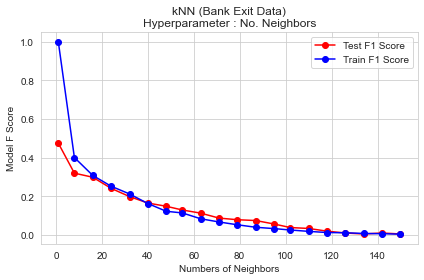

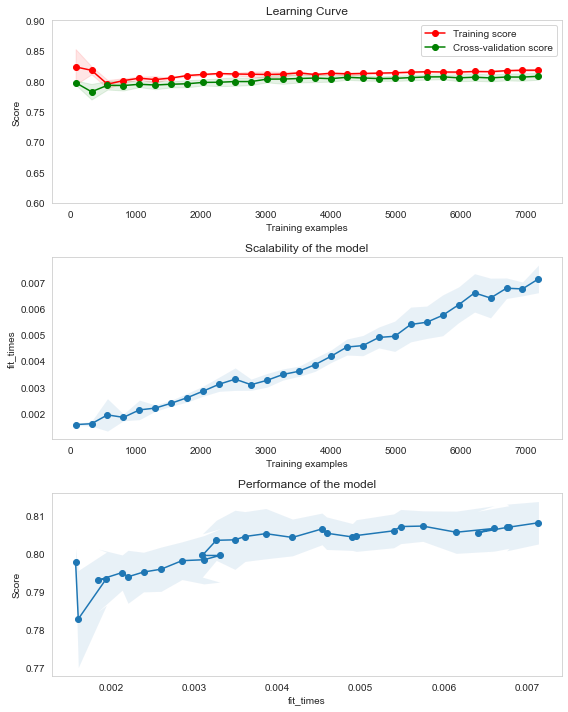

Train Resuls: 

Accuracy Report: 0.820 

Classification Report: 
              precision    recall  f1-score   support

           0       0.82      0.99      0.90      6374
           1       0.76      0.17      0.27      1626

    accuracy                           0.82      8000
   macro avg       0.79      0.58      0.59      8000
weighted avg       0.81      0.82      0.77      8000


Confusion Matrix Report: 
[[6286   88]
 [1353  273]]

Average Accuracy: 	0.808
Average SD: 	0.006


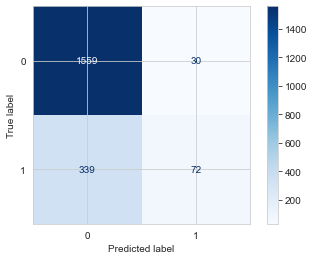

In [40]:
X_train, X_test, y_train, y_test = train_test_split(cusX,cusY, test_size=0.20)

KNN_fun(X_train, y_train, X_test, y_test,title="kNN (Bank Exit Data)\nHyperparameter : No. Neighbors")

estimator_churn = kNN(n_neighbors=20, n_jobs=-1)

estimator_churn.fit(X_train, y_train)

fig,axes = plt.subplots(3, figsize=(8, 10))

plt,knn_test_scores_bank, knn_fit_times_bank=plot_learning_curve(estimator_churn, title, X_train, y_train, axes=axes, ylim=(0.6, 0.9),cv=10)

plt.show()

plot_confusion_matrix(estimator_churn, X_test, y_test,cmap=plt.cm.Blues,
                                 normalize=None)
print_score(estimator_churn,X_train,y_train,X_test,y_test,train=True)





# SVM

In [38]:
def SVM_fun(X_train, y_train, X_test, y_test, title):

    f_test = []
    f_train = []
    kernel_func = ['poly','rbf']
    for a in kernel_func:         
            if a == 'poly':
                for j in [2,3,4,5]:
                    clf = SVC(kernel=a, degree=j,random_state=100)
                    clf.fit(X_train, y_train)
                    y_pred_test = clf.predict(X_test)
                    y_pred_train = clf.predict(X_train)
                    f_test.append(f1_score(y_test, y_pred_test))
                    f_train.append(f1_score(y_train, y_pred_train))
            else:    
                clf = SVC(kernel=a, random_state=100)
                clf.fit(X_train, y_train)
                y_pred_test = clf.predict(X_test)
                y_pred_train = clf.predict(X_train)
                f_test.append(f1_score(y_test, y_pred_test))
                f_train.append(f1_score(y_train, y_pred_train))
                
    xvals = ['poly2','poly3','poly4','poly5','rbf']
    plt.plot(xvals, f_test, 'o-', color='r', label='Test F1 Score')
    plt.plot(xvals, f_train, 'o-', color = 'b', label='Train F1 Score')
    plt.ylabel('Model F1 Score')
    plt.xlabel('Kernel Function')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

In [39]:
start_leaf_n = round(0.006*len(X_train))

end_leaf_n = round(0.06*len(X_train)) 

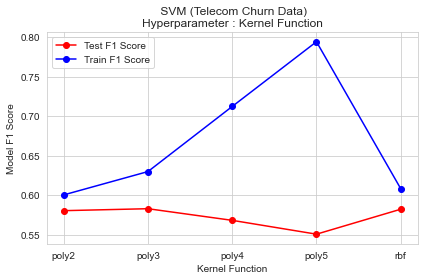

IN SVM
Per Hyperparameter tuning, best parameters are:
{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


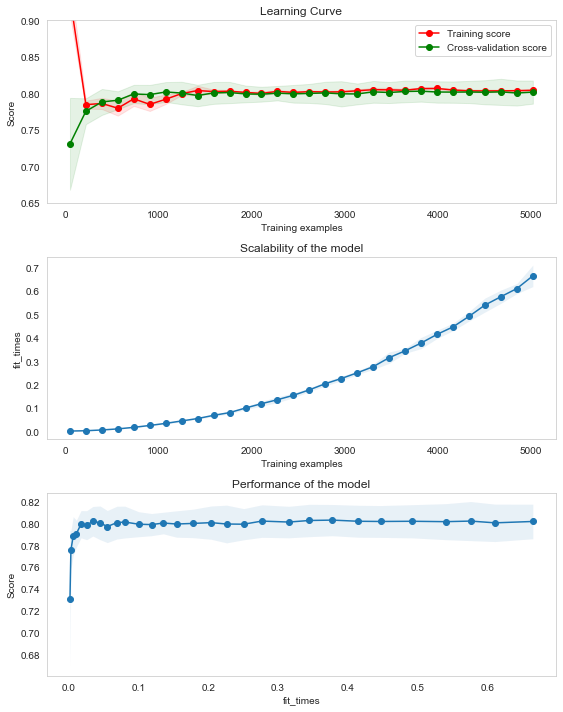

Train Resuls: 

Accuracy Report: 0.803 

Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      4105
           1       0.65      0.54      0.59      1475

    accuracy                           0.80      5580
   macro avg       0.75      0.72      0.73      5580
weighted avg       0.79      0.80      0.80      5580


Confusion Matrix Report: 
[[3681  424]
 [ 675  800]]

Average Accuracy: 	0.802
Average SD: 	0.016


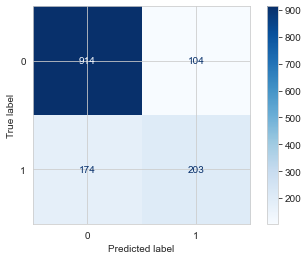

In [41]:
churnX,churnY,cusX,cusY = dataset_fun()

X_train, X_test, y_train, y_test = train_test_split(churnX,churnY, test_size=0.20)

SVM_fun(X_train, y_train, X_test, y_test,title=" SVM (Telecom Churn Data)\nHyperparameter : Kernel Function")

C_value, gamma_value = GridSearchCV_f(start_leaf_n,end_leaf_n,X_train,y_train,"SVM")

estimator_churn = SVC(C=C_value, gamma=gamma_value, kernel='rbf', random_state=100)

estimator_churn.fit(X_train, y_train)

fig,axes = plt.subplots(3, figsize=(8, 10))

plt,svm_test_scores_telecom, svm_fit_times_telecom=plot_learning_curve(estimator_churn, title, X_train, y_train, axes=axes, ylim=(0.65, 0.9),cv=10)

plt.show()

plot_confusion_matrix(estimator_churn, X_test, y_test,cmap=plt.cm.Blues,
                                 normalize=None)

print_score(estimator_churn,X_train,y_train,X_test,y_test,train=True)



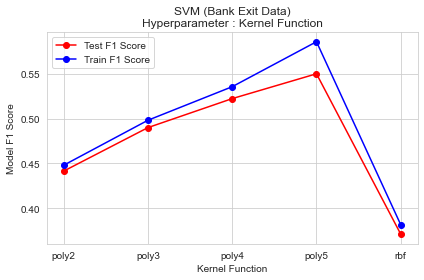

IN SVM
Per Hyperparameter tuning, best parameters are:
{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}


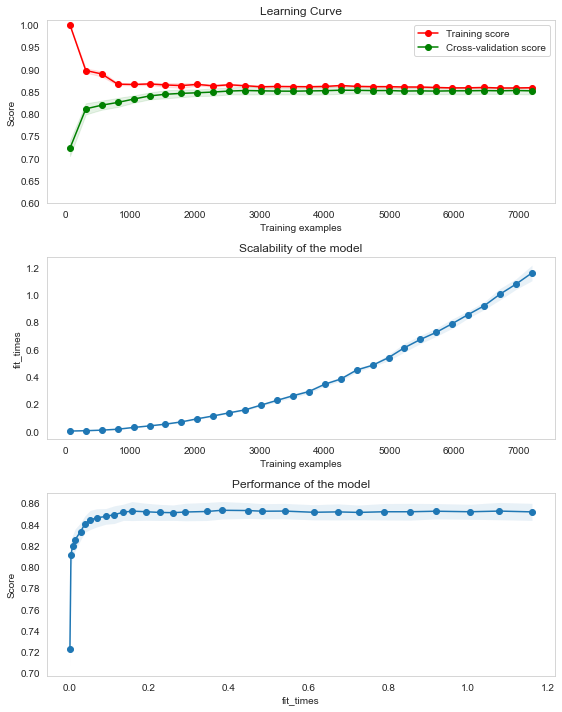

Train Results: 

Accuracy Report: 0.859 

Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.98      0.92      6345
           1       0.83      0.40      0.54      1655

    accuracy                           0.86      8000
   macro avg       0.84      0.69      0.73      8000
weighted avg       0.85      0.86      0.84      8000


Confusion Matrix Report: 
[[6205  140]
 [ 990  665]]

Average Accuracy: 	0.852
Average SD: 	0.008


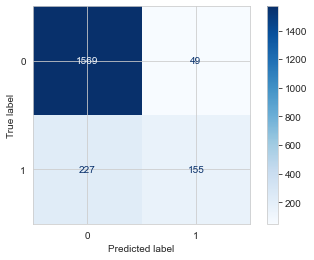

In [40]:
X_train, X_test, y_train, y_test = train_test_split(cusX,cusY, test_size=0.20)

SVM_fun(X_train, y_train, X_test, y_test,title="SVM (Bank Exit Data)\nHyperparameter : Kernel Function")

C_value, gamma_value = GridSearchCV_f(start_leaf_n,end_leaf_n,X_train,y_train,"SVM")

estimator_churn = SVC(C=C_value, gamma=gamma_value, kernel='rbf', random_state=100)

estimator_churn.fit(X_train, y_train)

fig,axes = plt.subplots(3, figsize=(8, 10))

plt,svm_test_scores_bank, svm_fit_times_bank=plot_learning_curve(estimator_churn, title, X_train, y_train, axes=axes, ylim=(0.6, 1.01),cv=10)

plt.show()

print_score(estimator_churn,X_train,y_train,X_test,y_test,train=True)

plot_confusion_matrix(estimator_churn, X_test, y_test,cmap=plt.cm.Blues,
                                 normalize=None)

# Neural Network

In [50]:
from sklearn.neural_network import MLPClassifier

def NN_fun(X_train, y_train, X_test, y_test, title):

    f_test = []
    f_train = []
    hidden_list = np.linspace(50,200,30).astype('int')
    for a in hidden_list:         
            clf = MLPClassifier(hidden_layer_sizes=(a), solver='adam', activation='relu', 
                                learning_rate_init=0.06, random_state=100)
            clf.fit(X_train, y_train)
            y_pred_test = clf.predict(X_test)
            y_pred_train = clf.predict(X_train)
            f_test.append(f1_score(y_test, y_pred_test))
            f_train.append(f1_score(y_train, y_pred_train))
      
    plt.plot(hidden_list, f_test, 'o-', color='r', label='Test F1 Score')
    plt.plot(hidden_list, f_train, 'o-', color = 'b', label='Train F1 Score')
    plt.ylabel('Model F1 Score')
    plt.xlabel('No. Hidden Units')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    

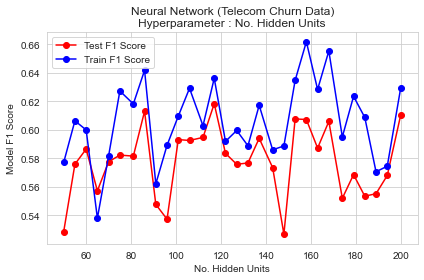

Per Hyperparameter tuning, best parameters are:
{'activation': 'relu', 'hidden_layer_sizes': 40, 'learning_rate_init': 0.1, 'solver': 'adam'}


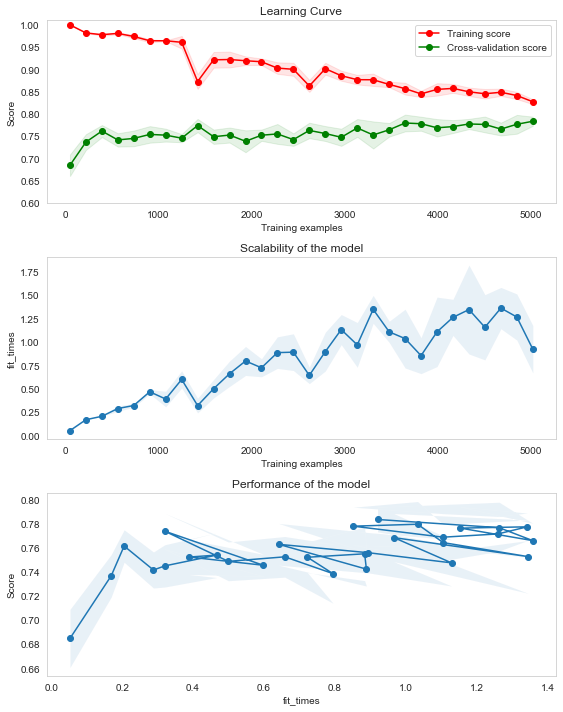

Train Results: 

Accuracy Report: 0.836 

Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.91      0.89      4121
           1       0.71      0.64      0.67      1459

    accuracy                           0.84      5580
   macro avg       0.79      0.77      0.78      5580
weighted avg       0.83      0.84      0.83      5580


Confusion Matrix Report: 
[[3737  384]
 [ 530  929]]

Average Accuracy: 	0.784
Average SD: 	0.010


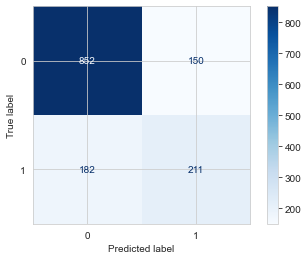

In [51]:
churnX,churnY,cusX,cusY = dataset_fun()

X_train, X_test, y_train, y_test = train_test_split(churnX,churnY, test_size=0.20)

NN_fun(X_train, y_train, X_test, y_test,title="Neural Network (Telecom Churn Data)\nHyperparameter : No. Hidden Units")

h_units, learn_rate = GridSearchCV_f(start_leaf_n,end_leaf_n,X_train,y_train,"NN")

estimator_churn = MLPClassifier(hidden_layer_sizes=(h_units,), solver='adam', activation='logistic', 
                               learning_rate_init=learn_rate, random_state=100)
estimator_churn.fit(X_train, y_train)

fig,axes = plt.subplots(3, figsize=(8, 10))

plt,nn_test_scores_telecom, nn_fit_times_telecom=plot_learning_curve(estimator_churn, title, X_train, y_train, axes=axes, ylim=(0.6, 1.01),cv=10)

plt.show()

plot_confusion_matrix(estimator_churn, X_test, y_test,cmap=plt.cm.Blues,
                                 normalize=None)
print_score(estimator_churn,X_train,y_train,X_test,y_test,train=True)


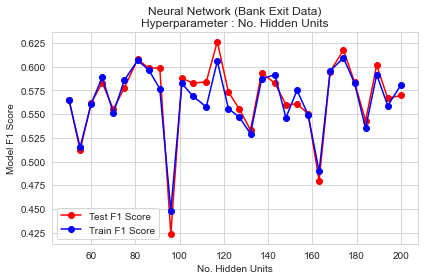

Per Hyperparameter tuning, best parameters are:
{'activation': 'relu', 'hidden_layer_sizes': 40, 'learning_rate_init': 0.01, 'solver': 'adam'}


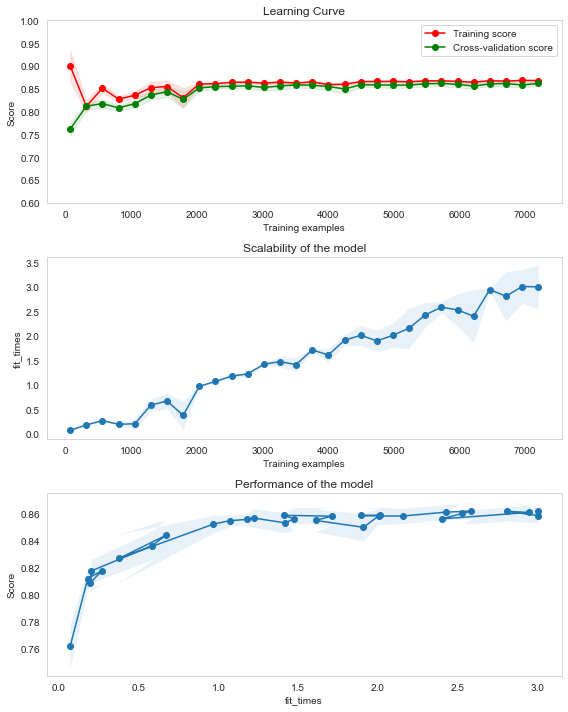

Train Results: 

Accuracy Report: 0.869 

Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.98      0.92      6399
           1       0.82      0.44      0.58      1601

    accuracy                           0.87      8000
   macro avg       0.85      0.71      0.75      8000
weighted avg       0.86      0.87      0.85      8000


Confusion Matrix Report: 
[[6243  156]
 [ 891  710]]

Average Accuracy: 	0.862
Average SD: 	0.005


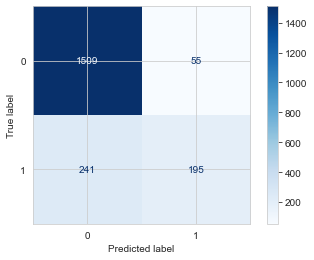

In [52]:
X_train, X_test, y_train, y_test = train_test_split(cusX,cusY, test_size=0.20)

NN_fun(X_train, y_train, X_test, y_test,title="Neural Network (Bank Exit Data)\nHyperparameter : No. Hidden Units")

h_units, learn_rate = GridSearchCV_f(start_leaf_n,end_leaf_n,X_train,y_train,"NN")

estimator_churn = MLPClassifier(hidden_layer_sizes=(h_units,), solver='adam', activation='logistic', 
                               learning_rate_init=learn_rate, random_state=100)
estimator_churn.fit(X_train, y_train)

fig,axes = plt.subplots(3, figsize=(8, 10))

plt,nn_test_scores_bank, nn_fit_times_bank=plot_learning_curve(estimator_churn, title, X_train, y_train, axes=axes, ylim=(0.6, 1),cv=10)

plt.show()

plot_confusion_matrix(estimator_churn, X_test, y_test,cmap=plt.cm.Blues,
                                 normalize=None)
print_score(estimator_churn,X_train,y_train,X_test,y_test,train=True)

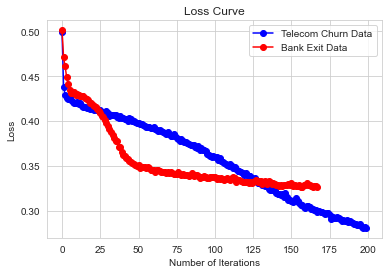

In [53]:
X_train, X_test, y_train, y_test = train_test_split(churnX,churnY, test_size=0.20)
estimator_churn = MLPClassifier(hidden_layer_sizes=h_units, solver='adam', activation='logistic', 
                               learning_rate_init=learn_rate, random_state=100)
estimator_churn.fit(X_train, y_train)
Telecom_Churn = estimator_churn.loss_curve_

X_train, X_test, y_train, y_test = train_test_split(cusX,cusY, test_size=0.20)
estimator_churn_cus = MLPClassifier(hidden_layer_sizes=h_units, solver='adam', activation='logistic', 
                               learning_rate_init=learn_rate, random_state=100)
estimator_churn_cus.fit(X_train, y_train)
Bank_Exit = estimator_churn_cus.loss_curve_

plt.figure()
plt.title("Loss Curve")
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.plot(Telecom_Churn, 'o-', color="b", label="Telecom Churn Data")
plt.plot(Bank_Exit, 'o-', color="r", label="Bank Exit Data")
plt.legend(loc="best")
plt.show()

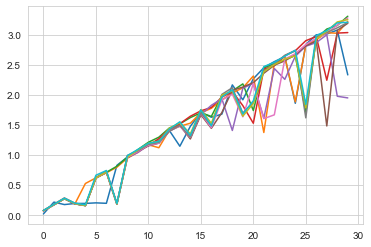

In [56]:
plt.plot(nn_fit_times_bank)